In [8]:
from pathlib import Path
import numpy as np
import pandas as pd
import time, os, re

import matplotlib.pyplot as plt
from scipy.stats import norm
from joblib import Parallel, delayed
from tqdm import tqdm

# MI/entropy estimators (KSG-style) from NPEET.
from npeet import entropy_estimators as ee

# Default plot resolution for notebook figures.
plt.rcParams["figure.dpi"] = 140

# Local data folders. Everything below is defined relative to this base.
DATA      = Path(r"C:\Users\bseis\ABthesis\data")
PROCESSED = DATA / "processed"
ANALYSIS  = DATA / "analysis"

# Prebuilt universe membership files for train/validation periods.
UNIV_TRAIN_FILE = PROCESSED / "crsp_weekly_universe_1997-01-01_to_2018-06-29_top1000_liq20p_rebalance-monthly_W-FRI.parquet"
UNIV_VALID_FILE = PROCESSED / "crsp_weekly_universe_2018-06-30_to_2024-12-30_top1000_liq20p_rebalance-monthly_W-FRI.parquet"

# Weekly core panels (default + an alternate explicitly versioned training cut).
CORE_DEFAULT = PROCESSED / "crsp_weekly_core.parquet"
CORE_ALT_B   = PROCESSED / "crsp_weekly_core_1997-01-01_to_2018-06-29.parquet"  # TRAIN

# Training window (inclusive), anchored to the as-of snapshot used for universe construction.
START_DATE = pd.Timestamp("1997-01-01")
END_DATE   = pd.Timestamp("2018-06-29")

# MI/NMI settings.
K_NEIGHBORS    = 6
MIN_OVERLAP    = 156       # require ~3 years of weekly overlap per pair
COVERAGE_FLOOR = 52        # drop tickers with <~1 year of data before pairwise checks
NORMALIZE_AS   = "sqrt"    # NMI denominator choice: 'sqrt' or 'min'

# Parallelization knobs.
N_JOBS      = max(1, os.cpu_count() - 1)
BATCH_PAIRS = 10000

# Make sure the output directory exists before anything tries to write to it.
ANALYSIS.mkdir(parents=True, exist_ok=True)

In [10]:
# Universe file defines membership over time; we take a single "as-of" snapshot for training.
assert UNIV_TRAIN_FILE.exists(), f"Missing {UNIV_TRAIN_FILE}"
uni = pd.read_parquet(UNIV_TRAIN_FILE).copy()
uni["date"]   = pd.to_datetime(uni["date"], errors="coerce")
uni["permno"] = pd.to_numeric(uni["permno"], errors="coerce").astype("Int64")

# Pick the as-of membership list: use END_DATE if it exists, otherwise fall back to the last date <= END_DATE.
if (uni["date"] == END_DATE).any():
    asof_slice = uni[(uni["date"] == END_DATE) & (uni["in_universe"].fillna(False))]
else:
    last_date = uni.loc[uni["date"] <= END_DATE, "date"].max()
    asof_slice = uni[(uni["date"] == last_date) & (uni["in_universe"].fillna(False))]

permnos_asof = asof_slice["permno"].dropna().astype(int).unique().tolist()
print(f"[universe] as-of {END_DATE.date()}: {len(permnos_asof)} PERMNOs")

# Load the weekly core panel for the training period (prefer the explicitly versioned TRAIN cut if present).
core_path = CORE_ALT_B if CORE_ALT_B.exists() else CORE_DEFAULT
assert core_path.exists(), f"Missing core at {core_path}"
core = pd.read_parquet(core_path).copy()
core["date"]   = pd.to_datetime(core["date"], errors="coerce")
core["permno"] = pd.to_numeric(core["permno"], errors="coerce").astype("Int64")
if "ticker" in core.columns:
    core["ticker"] = core["ticker"].astype(str).str.upper()

# Restrict to the training window and the as-of universe membership.
core = core[(core["date"] >= START_DATE) & (core["date"] <= END_DATE) & (core["permno"].isin(permnos_asof))].copy()

# Build a stable label for each PERMNO (ticker when available; otherwise a PERMNO_* fallback).
asof_map = (
    core.loc[core["date"] == core["date"].max(), ["permno","ticker","comnam"]]
        .drop_duplicates("permno")
        .copy()
)
asof_map["ticker"] = asof_map["ticker"].fillna("").astype(str)
asof_map["label"]  = asof_map.apply(
    lambda s: s["ticker"].strip().upper() if s["ticker"].strip() else f"PERMNO_{int(s['permno'])}",
    axis=1
)
label_map = dict(zip(asof_map["permno"].astype(int), asof_map["label"]))

[universe] as-of 2018-06-29: 1000 PERMNOs


In [12]:
RET_COL = "ret_total" if "ret_total" in core.columns else "ret"
assert RET_COL in core.columns, f"Neither 'ret_total' nor 'ret' found in {core_path.name}"

df_base = core.loc[:, ["date","permno",RET_COL]].copy()
df_base["ret_log"] = np.log1p(df_base[RET_COL])
df_base["permno"]  = df_base["permno"].astype("Int64")
df_base["date"]    = pd.to_datetime(df_base["date"])

# De-duplicate on (date, permno) robustly
dup_mask = df_base.duplicated(["date","permno"], keep=False)
if int(dup_mask.sum()) > 0:
    chk = (df_base[dup_mask]
           .groupby(["date","permno"])["ret_log"]
           .agg(["min","max","count"])
           .assign(spread=lambda d: d["max"] - d["min"]))
    if (chk["spread"] > 1e-10).any():
        df_base = df_base.groupby(["date","permno"], as_index=False).agg(ret_log=("ret_log","mean"))
    else:
        df_base = df_base.drop_duplicates(["date","permno"], keep="last")[["date","permno","ret_log"]]
else:
    df_base = df_base.groupby(["date","permno"], as_index=False).agg(ret_log=("ret_log","first"))

# Pivot to wide (columns = PERMNO)
df_ret = (
    df_base.pivot(index="date", columns="permno", values="ret_log")
           .sort_index()
           .dropna(how="all")
           .clip(lower=-0.99, upper=5.0)
)
# Relabel columns using as-of mapping; ensure uniqueness
new_cols = []
seen     = set()
for c in df_ret.columns.astype(int):
    lab = label_map.get(int(c), f"PERMNO_{int(c)}")
    if lab in seen:
        lab = f"{lab}_{int(c)}"
    seen.add(lab)
    new_cols.append(lab)
df_ret.columns = new_cols

print(f"[df_ret] shape={df_ret.shape} (weekly rows × assets)")


[df_ret] shape=(1122, 1000) (weekly rows × assets)


In [14]:
def gaussian_copula_transform(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index, columns=df.columns, dtype="float32")
    for col in df.columns:
        s = df[col].astype(float)
        notna = s.notna()
        if notna.sum() == 0:
            continue
        r = s[notna].rank(method="average")
        u = (r - 0.5) / float(len(r))
        z = norm.ppf(u.clip(eps, 1 - eps))
        out.loc[notna, col] = z.astype("float32")
    return out

df_z = gaussian_copula_transform(df_ret)
print(f"[df_z] shape={df_z.shape}")

[df_z] shape=(1122, 1000)


In [16]:
def entropy_bits_1d(x: np.ndarray, k: int = 6) -> float:
    """Differential entropy (bits) with NPEET; returns np.nan if too short."""
    x = np.asarray(x, dtype=float).reshape(-1, 1)
    if x.shape[0] <= k:
        return np.nan
    h_nats = float(ee.entropy(x, k=k))
    return h_nats / np.log(2.0)

def ksg_mi_bits(x: np.ndarray, y: np.ndarray, k: int = 6) -> float:
    """KSG MI in bits via NPEET; clips small negatives to 0."""
    x = np.asarray(x, dtype=float).reshape(-1, 1)
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    if min(x.shape[0], y.shape[0]) <= k:
        return np.nan
    mi_nats = float(ee.mi(x, y, k=k))
    mi_bits = mi_nats / np.log(2.0)
    return max(mi_bits, 0.0)

H_raw = pd.Series(
    {col: entropy_bits_1d(df_ret[col].dropna().to_numpy(), k=K_NEIGHBORS)
     for col in df_ret.columns},
    name="entropy_bits_raw"
)
print(f"[H_raw] mean={H_raw.mean():.4f} bits | std={H_raw.std():.4f} | "
      f"min={H_raw.min():.4f} | max={H_raw.max():.4f}")

[H_raw] mean=-3.4892 bits | std=0.6162 | min=-4.9355 | max=-1.7634


In [18]:
cols = list(df_z.columns)
p = len(cols)

# Coverage prefilter (keeps columns with >= COVERAGE_FLOOR non-null)
keep = [c for c in cols if df_z[c].notna().sum() >= COVERAGE_FLOOR]
df_z_sub  = df_z[keep].copy()
df_ret_sub= df_ret[keep].copy()
H_raw_sub = H_raw.reindex(keep)

print(f"[coverage] kept {len(keep)}/{p} assets with >= {COVERAGE_FLOOR} non-null weeks")

# Pairs
pairs = [(i, j) for i in range(len(keep)) for j in range(i+1, len(keep))]
R = np.full((len(keep), len(keep)), np.nan, dtype=float)

def _mi_for_chunk(chunk_pairs):
    out = []
    for (i, j) in chunk_pairs:
        xi = df_z_sub.iloc[:, i]
        yj = df_z_sub.iloc[:, j]
        mask = xi.notna() & yj.notna()
        if int(mask.sum()) < MIN_OVERLAP:
            out.append((i, j, np.nan)); continue
        x = xi[mask].to_numpy()
        y = yj[mask].to_numpy()
        try:
            v = ksg_mi_bits(x, y, k=K_NEIGHBORS)
        except Exception:
            v = np.nan
        out.append((i, j, v))
    return out

t0 = time.time()
for start in tqdm(range(0, len(pairs), BATCH_PAIRS), desc="MI (bits) batches", unit="batch"):
    end   = min(start + BATCH_PAIRS, len(pairs))
    chunk = pairs[start:end]
    # shard chunk into ~4× n_jobs pieces for load balancing
    n_shards = max(4*N_JOBS, 1)
    shards   = np.array_split(chunk, n_shards)

    if N_JOBS == 1:
        flat = []
        for sh in shards:
            flat.extend(_mi_for_chunk(list(sh)))
    else:
        jobs = [delayed(_mi_for_chunk)(list(sh)) for sh in shards if len(sh)]
        shard_lists = Parallel(n_jobs=N_JOBS, prefer="threads")(jobs)
        flat = [itm for sub in shard_lists for itm in sub]

    for i, j, v in flat:
        R[i, j] = R[j, i] = v

elapsed = time.time() - t0
print(f"[MI] computed {len(pairs):,} pairs in {elapsed:,.1f}s")

R_mi = pd.DataFrame(R, index=keep, columns=keep)

[coverage] kept 1000/1000 assets with >= 52 non-null weeks


MI (bits) batches: 100%|████████████████████████████████████████████████████████████| 50/50 [42:26<00:00, 50.93s/batch]

[MI] computed 499,500 pairs in 2,546.6s


In [21]:
# Denominator using entropies on RAW log returns
Hvec = H_raw_sub.to_numpy()
den  = np.sqrt(np.outer(Hvec, Hvec)) if NORMALIZE_AS == "sqrt" else np.minimum.outer(Hvec, Hvec)

N = R_mi.to_numpy(copy=True)
with np.errstate(invalid="ignore", divide="ignore"):
    N = N / np.where(den > 0, den, np.nan)

# Diagonal to 1 where H_i>0
for i in range(N.shape[0]):
    N[i, i] = 1.0 if np.isfinite(Hvec[i]) and (Hvec[i] > 0) else np.nan

R_nmi_rawH = pd.DataFrame(N, index=keep, columns=keep)

# Diagnostics
def upper_vec(M: pd.DataFrame) -> np.ndarray:
    A  = M.to_numpy()
    iu = np.triu_indices_from(A, 1)
    v  = A[iu]
    return v[np.isfinite(v)]

v_mi  = upper_vec(R_mi)
v_nmi = upper_vec(R_nmi_rawH)

corr  = np.corrcoef(v_mi, v_nmi)[0,1]
scale = np.nanmean(v_mi / np.maximum(v_nmi, 1e-12))

print(f"Corr(MI (bits), NMI_rawH) = {corr:.6f}  (now should be <~1 if H varies)")
print(f"Mean scale MI/NMI ≈ {scale:.3f}")

# quick summaries
def summarize(M, name):
    v = upper_vec(M)
    print(f"[{name}] pairs={len(v):,} | mean={np.nanmean(v):.4f} | median={np.nanmedian(v):.4f} "
          f"| p5={np.nanpercentile(v,5):.4f} | p95={np.nanpercentile(v,95):.4f}")
summarize(R_mi, "MI bits")
summarize(R_nmi_rawH, "NMI (rawH)")

Corr(MI (bits), NMI_rawH) = 0.979372  (now should be <~1 if H varies)
Mean scale MI/NMI ≈ 3.250
[MI bits] pairs=452,676 | mean=0.1338 | median=0.1167 | p5=0.0000 | p95=0.3158
[NMI (rawH)] pairs=452,676 | mean=0.0389 | median=0.0339 | p5=0.0000 | p95=0.0920


In [23]:
asof_str = END_DATE.strftime("%Y%m%d")
base     = f"tier1_asof{asof_str}_k{K_NEIGHBORS}_min{MIN_OVERLAP}"

mi_path   = ANALYSIS / f"mi_bits_{base}.parquet"
nmi_path  = ANALYSIS / f"nmi_rawH_{NORMALIZE_AS}_{base}.parquet"
H_path    = ANALYSIS / f"entropy_bits_raw_{base}.parquet"

R_mi.to_parquet(mi_path)
R_nmi_rawH.to_parquet(nmi_path)
H_raw_sub.to_frame().to_parquet(H_path)

print("[saved]")
print("  MI (bits):", mi_path)
print("  NMI (rawH):", nmi_path)
print("  H_raw (bits):", H_path)

[saved]
  MI (bits): C:\Users\bseis\ABthesis\data\analysis\mi_bits_tier1_asof20180629_k6_min156.parquet
  NMI (rawH): C:\Users\bseis\ABthesis\data\analysis\nmi_rawH_sqrt_tier1_asof20180629_k6_min156.parquet
  H_raw (bits): C:\Users\bseis\ABthesis\data\analysis\entropy_bits_raw_tier1_asof20180629_k6_min156.parquet


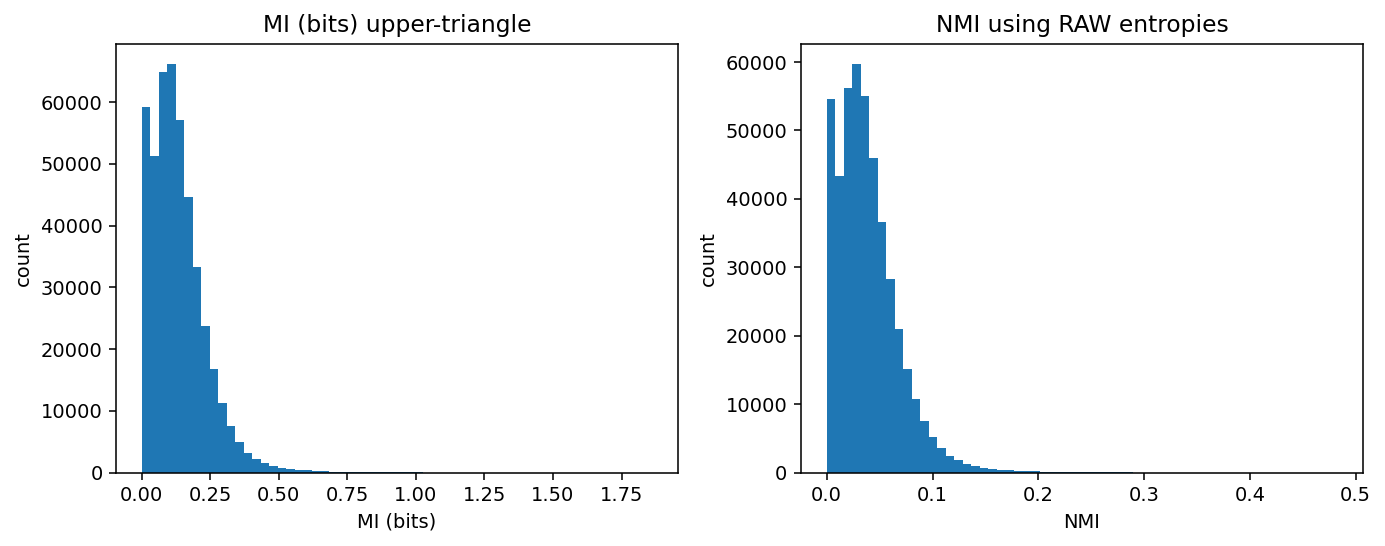

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(upper_vec(R_mi), bins=60)
ax[0].set_title("MI (bits) upper-triangle")
ax[0].set_xlabel("MI (bits)"); ax[0].set_ylabel("count")

ax[1].hist(upper_vec(R_nmi_rawH), bins=60)
ax[1].set_title("NMI using RAW entropies")
ax[1].set_xlabel("NMI"); ax[1].set_ylabel("count")

fig.tight_layout(); plt.show()

### New Approach

In [18]:
import numpy as np
import pandas as pd

# Prefer total returns when available (handles delistings), otherwise fall back to raw returns.
VALUE_COL = "ret_total" if "ret_total" in panel.columns else "ret"
assert VALUE_COL in panel.columns, f"{VALUE_COL} not found in panel!"

# Filter to the universe and keep only what we need for the pivot.
df_base = (
    panel.loc[panel["permno"].isin(today_universe), ["date", "permno", VALUE_COL]]
          .copy()
)
df_base["date"] = pd.to_datetime(df_base["date"])
df_base["permno"] = pd.to_numeric(df_base["permno"], errors="coerce").astype("Int64")

# Work in log returns for stability (and easier aggregation if duplicates exist).
df_base["ret_log"] = np.log1p(df_base[VALUE_COL])

# Pivot expects unique (date, permno) keys, so deal with duplicates explicitly.
dup_mask = df_base.duplicated(["date", "permno"], keep=False)
n_dup_rows = int(dup_mask.sum())
if n_dup_rows:
    n_dup_keys = (
        df_base.loc[dup_mask, ["date", "permno"]]
               .drop_duplicates()
               .shape[0]
    )
    print(f"[note] Found {n_dup_rows:,} duplicate rows across {n_dup_keys:,} (date, permno) keys.")

    # Check whether duplicates actually disagree or are just repeated entries.
    chk = (df_base[dup_mask]
           .groupby(["date","permno"])["ret_log"]
           .agg(["min","max","count"])
           .assign(spread=lambda d: d["max"] - d["min"]))
    big_spreads = chk[chk["spread"] > 1e-10]

    if not big_spreads.empty:
        print(f"[warn] {len(big_spreads):,} duplicate keys have non-trivial value differences; using mean.")
        df_base = (df_base.groupby(["date","permno"], as_index=False)
                          .agg(ret_log=("ret_log","mean")))
    else:
        # If the values match, just keep one row per key.
        df_base = (df_base.drop_duplicates(["date","permno"], keep="last")
                          .loc[:, ["date","permno","ret_log"]])
else:
    # Even without duplicates, this keeps the shape consistent and ensures one row per key.
    df_base = (df_base.groupby(["date","permno"], as_index=False)
                      .agg(ret_log=("ret_log","first")))

# Wide table: rows are weeks, columns are PERMNOs.
df_ret = (
    df_base.pivot(index="date", columns="permno", values="ret_log")
           .sort_index()
)

# Drop weeks where nothing in the universe traded / reported data.
df_ret = df_ret.dropna(how="all")

print(df_ret.shape, "weekly rows x permnos")
df_ret.tail()

[note] Found 397,112 duplicate rows across 198,556 (date, permno) keys.
[warn] 133,525 duplicate keys have non-trivial value differences; using mean.
(1122, 1000) weekly rows x permnos


permno,10104,10107,10138,10145,10182,10220,10302,10375,10397,10516,10517,10629,10693,10696,10777,...,93132,93150,93174,93179,93246,93264,93295,93312,93330,93374,93420,93422,93423,93429,93436
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-01,0.000721,0.014637,0.006388,-0.011105,0.078198,-0.010171,-0.000625,0.000370,0.010823,-0.017664,-0.025156,-0.006993,0.024113,0.016500,-0.003065,...,0.019986,-0.030076,-0.005656,-0.067486,0.024667,0.068011,0.005389,0.015615,0.001005,-0.039117,0.076027,-0.017913,0.029063,-0.047983,0.033166
2018-06-08,0.017377,0.008301,0.024751,0.011725,-0.007272,-0.001336,0.023112,0.024942,-0.037256,0.023233,0.034962,0.048649,0.020877,0.028765,-0.003635,...,0.008512,0.034577,0.040588,0.040267,0.012217,-0.047946,-0.002450,0.014619,0.030786,0.019127,-0.025336,-0.013652,0.064888,0.054666,0.084845
2018-06-15,-0.040234,-0.014869,-0.004649,-0.010791,0.014154,-0.029682,0.046920,-0.037839,0.023287,0.025970,0.059414,-0.020767,0.021189,0.013425,-0.028222,...,0.043040,-0.021151,-0.007441,0.046745,0.028955,0.051750,-0.037628,0.031240,-0.000490,-0.013406,-0.068382,-0.031416,0.024600,-0.010931,0.120026
2018-06-22,-0.048249,0.002793,-0.013648,-0.042354,-0.046253,-0.048569,-0.045748,-0.018498,0.017745,0.010805,0.030764,0.007210,-0.012031,-0.012101,-0.034740,...,-0.020896,0.007035,0.010978,-0.077809,-0.040774,0.047654,0.059950,0.028838,-0.011811,-0.024789,0.137479,0.084942,0.003719,0.020790,-0.070975
2018-06-29,-0.000907,-0.018090,-0.057819,0.000348,-0.033527,0.000482,-0.085628,-0.043321,-0.055800,-0.015159,-0.039487,-0.036580,0.015570,-0.019779,-0.027850,...,-0.023742,-0.018475,-0.006549,0.024133,0.024857,-0.011440,-0.020974,-0.055832,-0.013959,0.021893,-0.060579,-0.001630,-0.037133,-0.008706,0.027552


In [7]:
panel = pd.read_parquet(DATA_CORE)

# Time window and universe (align with redundancy notebook)
START_DATE = pd.Timestamp("1997-01-01")
END_DATE   = pd.Timestamp("2018-06-30")

panel["date"] = pd.to_datetime(panel["date"])
panel = panel.loc[(panel["date"] >= START_DATE) & (panel["date"] <= END_DATE)].copy()

ASOF_DATE = panel["date"].max()
today_universe = (
    panel.loc[panel["date"].eq(ASOF_DATE) & panel["in_universe"].fillna(False), "permno"]
          .dropna().astype(int).unique().tolist()
)
print(f"As-of {ASOF_DATE.date()} (cut at {END_DATE.date()}): universe size = {len(today_universe):,}")

# Build label map (permno → ticker)
asof_map = (
    panel.loc[panel["date"].eq(ASOF_DATE) & panel["permno"].isin(today_universe),
              ["permno", "ticker", "comnam"]]
         .drop_duplicates("permno")
         .copy()
)
asof_map["ticker"] = asof_map["ticker"].fillna("").astype(str)
asof_map["label"] = asof_map.apply(
    lambda s: s["ticker"].upper() if s["ticker"].strip() else f"PERMNO_{int(s['permno'])}", axis=1
)
label_map = dict(zip(asof_map["permno"].astype(int), asof_map["label"]))

As-of 2018-06-29 (cut at 2018-06-30): universe size = 1,000
label_map size = 1,000 (expect ~1,000)
examples: [(10104, 'ORCL'), (10107, 'MSFT'), (10138, 'TROW'), (10145, 'HON'), (10182, 'TECD')]


C:\Users\bseis\AppData\Local\Temp\ipykernel_17196\2342713555.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(asof_map["ticker"]):


In [30]:
VALUE_COL = "ret_total" if "ret_total" in panel.columns else "ret"
assert VALUE_COL in panel.columns, f"{VALUE_COL} not found in panel!"

# Subset + compute log returns
df_base = (
    panel.loc[panel["permno"].isin(today_universe), ["date", "permno", VALUE_COL]]
          .copy()
)
df_base["date"] = pd.to_datetime(df_base["date"])
df_base["permno"] = pd.to_numeric(df_base["permno"], errors="coerce").astype("Int64")
df_base["ret_log"] = np.log1p(df_base[VALUE_COL])

# Diagnose duplicates on the pivot keys
dup_mask = df_base.duplicated(["date", "permno"], keep=False)
n_dup_rows = int(dup_mask.sum())
if n_dup_rows:
    n_dup_keys = (
        df_base.loc[dup_mask, ["date", "permno"]]
               .drop_duplicates()
               .shape[0]
    )
    print(f"[note] Found {n_dup_rows:,} duplicate rows across {n_dup_keys:,} (date, permno) keys.")
    # Optional: check if duplicate values essentially agree
    chk = (df_base[dup_mask]
           .groupby(["date","permno"])["ret_log"]
           .agg(["min","max","count"])
           .assign(spread=lambda d: d["max"] - d["min"]))
    big_spreads = chk[chk["spread"] > 1e-10]
    if not big_spreads.empty:
        print(f"[warn] {len(big_spreads):,} duplicate keys have non-trivial value differences; using mean.")
        # If you prefer a different policy, switch 'mean' -> 'last' or 'first'
        df_base = (df_base.groupby(["date","permno"], as_index=False)
                          .agg(ret_log=("ret_log","mean")))
    else:
        # Values are effectively the same—just pick one (faster)
        df_base = (df_base.drop_duplicates(["date","permno"], keep="last")
                          .loc[:, ["date","permno","ret_log"]])
else:
    # No duplicates—still normalize shape via a cheap groupby-first
    df_base = (df_base.groupby(["date","permno"], as_index=False)
                      .agg(ret_log=("ret_log","first")))

# Pivot to wide
df_ret = (
    df_base.pivot(index="date", columns="permno", values="ret_log")
           .sort_index()
)

# Drop all-NaN rows (weeks where none of the chosen permnos had data)
df_ret = df_ret.dropna(how="all")

print(df_ret.shape, "weekly rows x permnos")
df_ret.tail()

[note] Found 397,112 duplicate rows across 198,556 (date, permno) keys.
[warn] 133,525 duplicate keys have non-trivial value differences; using mean.
(1122, 1000) weekly rows x permnos


permno,10104,10107,10138,10145,10182,10220,10302,10375,10397,10516,10517,10629,10693,10696,10777,...,93132,93150,93174,93179,93246,93264,93295,93312,93330,93374,93420,93422,93423,93429,93436
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-01,0.000721,0.014637,0.006388,-0.011105,0.078198,-0.010171,-0.000625,0.000370,0.010823,-0.017664,-0.025156,-0.006993,0.024113,0.016500,-0.003065,...,0.019986,-0.030076,-0.005656,-0.067486,0.024667,0.068011,0.005389,0.015615,0.001005,-0.039117,0.076027,-0.017913,0.029063,-0.047983,0.033166
2018-06-08,0.017377,0.008301,0.024751,0.011725,-0.007272,-0.001336,0.023112,0.024942,-0.037256,0.023233,0.034962,0.048649,0.020877,0.028765,-0.003635,...,0.008512,0.034577,0.040588,0.040267,0.012217,-0.047946,-0.002450,0.014619,0.030786,0.019127,-0.025336,-0.013652,0.064888,0.054666,0.084845
2018-06-15,-0.040234,-0.014869,-0.004649,-0.010791,0.014154,-0.029682,0.046920,-0.037839,0.023287,0.025970,0.059414,-0.020767,0.021189,0.013425,-0.028222,...,0.043040,-0.021151,-0.007441,0.046745,0.028955,0.051750,-0.037628,0.031240,-0.000490,-0.013406,-0.068382,-0.031416,0.024600,-0.010931,0.120026
2018-06-22,-0.048249,0.002793,-0.013648,-0.042354,-0.046253,-0.048569,-0.045748,-0.018498,0.017745,0.010805,0.030764,0.007210,-0.012031,-0.012101,-0.034740,...,-0.020896,0.007035,0.010978,-0.077809,-0.040774,0.047654,0.059950,0.028838,-0.011811,-0.024789,0.137479,0.084942,0.003719,0.020790,-0.070975
2018-06-29,-0.000907,-0.018090,-0.057819,0.000348,-0.033527,0.000482,-0.085628,-0.043321,-0.055800,-0.015159,-0.039487,-0.036580,0.015570,-0.019779,-0.027850,...,-0.023742,-0.018475,-0.006549,0.024133,0.024857,-0.011440,-0.020974,-0.055832,-0.013959,0.021893,-0.060579,-0.001630,-0.037133,-0.008706,0.027552


In [21]:
def gaussian_copula_transform(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    """
    Rank -> U(0,1) -> N(0,1) per column; NaNs preserved. Returns float32 for memory.
    """
    out = pd.DataFrame(index=df.index, columns=df.columns, dtype="float32")
    n_cols = df.shape[1]
    for j, col in enumerate(df.columns, 1):
        s = df[col].astype(float)
        notna = s.notna()
        if notna.sum() == 0:
            continue
        r = s[notna].rank(method="average")
        u = (r - 0.5) / float(len(r))
        z = norm.ppf(u.clip(eps, 1 - eps))
        out.loc[notna, col] = z.astype("float32")
    return out

df_z = gaussian_copula_transform(df_ret)
df_z.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1122 entries, 1997-01-03 to 2018-06-29
Columns: 1000 entries, 10104 to 93436
dtypes: float32(1000)
memory usage: 4.3 MB


In [22]:
# ------- Cell 5: Pairwise MI/NMI on maximal overlap -------
def _entropy_bits_1d(x: np.ndarray, k: int = 6) -> float:
    """
    Differential entropy (bits) using NPEET's ee.entropy via ksg_tools' conventions.
    x: 1D array (finite). Returns np.nan if too short.
    """
    from npeet import entropy_estimators as ee
    x = np.asarray(x, dtype=float).reshape(-1, 1)
    if x.shape[0] <= k:
        return np.nan
    h_nats = float(ee.entropy(x, k=k))
    return h_nats / np.log(2.0)

def compute_pairwise_mi_nmi(
    df: pd.DataFrame,
    *,
    k: int = 6,
    min_obs: int = 156,     
    normalize: str | None = "sqrt",
    n_jobs: int = max(1, os.cpu_count() - 1),
    batch_pairs: int = 10000, 
    desc: str = "MI",
    return_mi: bool = True,
):
    """
    Compute pairwise KSG MI (bits) on per-pair maximal overlap. Optionally normalize to NMI.

    Returns
    -------
    (R_nmi, R_mi, entropies_bits)
      R_nmi : DataFrame (normalized MI if normalize given; else None)
      R_mi  : DataFrame (raw MI in bits)
      H     : Series of entropies (bits) per column
    """
    cols = list(df.columns)
    p = len(cols)
    # Precompute entropies (on each column's non-null)
    H = np.full(p, np.nan, dtype=float)
    for j, col in enumerate(cols):
        x = df[col].dropna().to_numpy()
        H[j] = _entropy_bits_1d(x, k=k)

    # Build pair list (upper triangle i<j)
    pairs = [(i, j) for i in range(p) for j in range(i + 1, p)]
    n_pairs = len(pairs)

    # Shared arrays (MI in bits)
    R = np.full((p, p), np.nan, dtype=float)

    # Helper to compute MI for a chunk of pairs
    def _eval_chunk(chunk_pairs):
        out = []
        for (i, j) in chunk_pairs:
            xi = df.iloc[:, i]
            yj = df.iloc[:, j]
            mask = xi.notna() & yj.notna()
            n_ij = int(mask.sum())
            if n_ij < min_obs:
                out.append((i, j, np.nan))
                continue
            x = xi[mask].to_numpy()
            y = yj[mask].to_numpy()
            try:
                mi_bits = ksg_mi_estimator_I(x, y, k=k, return_bits=True, jitter_if_ties=True)
            except Exception:
                mi_bits = np.nan
            out.append((i, j, mi_bits))
        return out

    # Process in batches with ETA
    t0 = time.time()
    for start in tqdm(range(0, n_pairs, batch_pairs), desc=desc, unit="batch"):
        end = min(start + batch_pairs, n_pairs)
        chunk = pairs[start:end]
    
        # Split chunk into shards (more than n_jobs helps load balance)
        n_workers = max(1, n_jobs)
        n_shards = max(n_workers * 4, 1)
        shards = np.array_split(chunk, n_shards)
    
        if n_workers == 1:
            # Sequential fallback (useful for debugging)
            flat = []
            for sh in shards:
                flat.extend(_eval_chunk(list(sh)))
        else:
            # Proper list of delayed jobs (NOT a single delayed object)
            jobs = [delayed(_eval_chunk)(list(sh)) for sh in shards if len(sh)]
            shard_lists = Parallel(n_jobs=n_workers, prefer="threads")(jobs)
            # Flatten list-of-lists
            flat = [item for sub in shard_lists for item in sub]
    
        # Write results
        for i, j, v in flat:
            R[i, j] = R[j, i] = v
    
        # ETA
        done = end
        elapsed = time.time() - t0
        rate = done / elapsed if elapsed > 0 else float("inf")
        remaining = n_pairs - done
        eta_s = remaining / rate if rate > 0 else float("inf")
        print(f"  pairs done: {done:,}/{n_pairs:,} | elapsed {elapsed:,.1f}s | ETA {eta_s:,.1f}s")


    # Wrap as DataFrame
    R_mi = pd.DataFrame(R, index=cols, columns=cols)

    # Normalization to NMI
    if normalize is None:
        R_nmi = None
    else:
        Hvec = H.copy()
        # diag=H, off-diag=MI
        # sqrt: I / sqrt(H_i*H_j); min: I / min(H_i,H_j)
        if normalize == "sqrt":
            denom = np.sqrt(np.outer(Hvec, Hvec))
        elif normalize == "min":
            denom = np.minimum.outer(Hvec, Hvec)
        else:
            raise ValueError("normalize must be one of {None,'sqrt','min'}")

        with np.errstate(invalid="ignore", divide="ignore"):
            N = R / denom
        # Populate diagonal to 1.0 where H>0
        for i in range(p):
            if np.isfinite(Hvec[i]) and Hvec[i] > 0:
                N[i, i] = 1.0
            else:
                N[i, i] = np.nan
        R_nmi = pd.DataFrame(N, index=cols, columns=cols)

    # Entropies series
    H_ser = pd.Series(H, index=cols, name="entropy_bits")
    return R_nmi, R_mi if return_mi else None, H_ser

In [24]:
# ------- Cell 6: Small subset (quick check) -------
SUBSET_SIZE   = 40
K_NEIGHBORS   = 6
MIN_OVERLAP   = 156
NORMALIZE_AS  = "sqrt"
JOBS          = max(1, os.cpu_count() - 1)

# Choose top-covered columns
coverage = df_z.notna().sum().sort_values(ascending=False)
subset_cols = coverage.head(SUBSET_SIZE).index.tolist()
df_small = df_z[subset_cols].copy()

print(f"Subset columns: {len(subset_cols)}")
display(pd.Series(subset_cols[:10], name="first 10 names"))

R_nmi_s, R_mi_s, H_s = compute_pairwise_mi_nmi(
    df_small,
    k=K_NEIGHBORS,
    min_obs=MIN_OVERLAP,
    normalize=NORMALIZE_AS,
    n_jobs=JOBS,
    batch_pairs=3000,
    desc="MI (subset)",
    return_mi=True,
)

print("Done. Shapes:", 
      "NMI" if R_nmi_s is not None else "MI only", 
      R_nmi_s.shape if R_nmi_s is not None else None, 
      "MI", R_mi_s.shape)

Subset columns: 40


0    10104
1    60943
2    59619
3    60206
4    60442
5    60506
6    60580
7    60599
8    60628
9    60687
Name: first 10 names, dtype: int64

MI (subset):   0%|          | 0/1 [00:00<?, ?batch/s]

  pairs done: 780/780 | elapsed 2.5s | ETA 0.0s
Done. Shapes: NMI (40, 40) MI (40, 40)


[Subset NMI] negatives=0.00% | zeros=0.00% | mean=0.0651 | median=0.0620


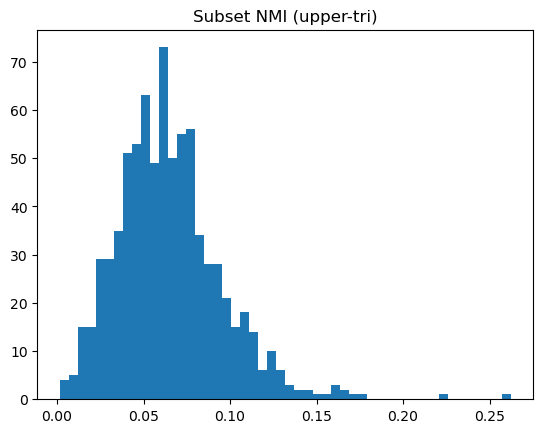

[Subset MI bits] negatives=0.00% | zeros=0.00% | mean=0.2046 | median=0.1950


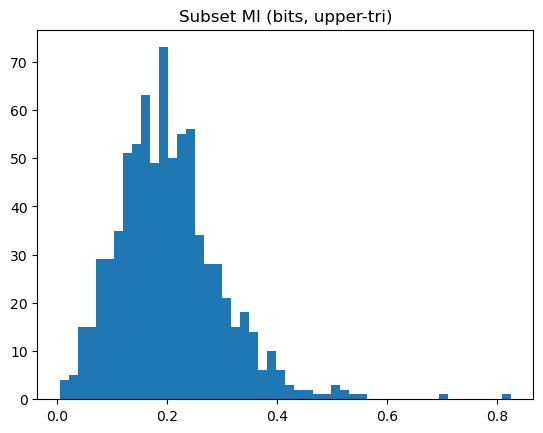

In [27]:
import matplotlib.pyplot as plt

def _vec_upper(dfM: pd.DataFrame) -> np.ndarray:
    A = dfM.values
    iu = np.triu_indices_from(A, k=1)
    return A[iu]

if R_nmi_s is not None:
    v = _vec_upper(R_nmi_s)
    v = v[np.isfinite(v)]
    neg_pct = (v < 0).mean() * 100
    zero_pct = (v == 0).mean() * 100
    print(f"[Subset NMI] negatives={neg_pct:.2f}% | zeros={zero_pct:.2f}% | mean={np.nanmean(v):.4f} | median={np.nanmedian(v):.4f}")
    plt.figure()
    plt.hist(v, bins=50)
    plt.title("Subset NMI (upper-tri)"); plt.show()

v_mi = _vec_upper(R_mi_s)
v_mi = v_mi[np.isfinite(v_mi)]
neg_pct = (v_mi < 0).mean() * 100
zero_pct = (v_mi == 0).mean() * 100
print(f"[Subset MI bits] negatives={neg_pct:.2f}% | zeros={zero_pct:.2f}% | mean={np.nanmean(v_mi):.4f} | median={np.nanmedian(v_mi):.4f}")
plt.figure()
plt.hist(v_mi, bins=50)
plt.title("Subset MI (bits, upper-tri)"); plt.show()

In [28]:
# Settings for the full run.
# require ~3 years of overlapping weekly data per pair
K_NEIGHBORS    = 6
MIN_OVERLAP    = 156       
NORMALIZE_AS   = "sqrt"   
JOBS           = max(1, os.cpu_count() - 1)
BATCH_PAIRS    = 10000       
COVERAGE_FLOOR = 52  

# df_z should already exist (Gaussian-copula returns). If not, rebuild it from panel + today_universe.
if "df_z" not in globals():
    # Build a wide weekly log-return table.
    VALUE_COL = "ret_total" if "ret_total" in panel.columns else "ret"
    df_ret = (
        panel.loc[panel["permno"].isin(today_universe), ["date","permno", VALUE_COL]]
              .assign(ret_log=lambda d: np.log1p(d[VALUE_COL]))
              .pivot_table(index="date", columns="permno", values="ret_log", aggfunc="mean")
              .sort_index()
              .dropna(how="all")
    )

    # Optional relabeling so downstream matrices have readable column names.
    permnos_in_wide = pd.Index(df_ret.columns).astype(int)
    df_ret.columns = [label_map.get(int(c), f"PERMNO_{int(c)}") for c in permnos_in_wide]

    # Gaussian copula transform: rank -> uniform -> Normal quantile.
    from scipy.stats import norm
    def gaussian_copula_transform(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
        out = pd.DataFrame(index=df.index, columns=df.columns, dtype="float32")
        for col in df.columns:
            s = df[col].astype(float)
            notna = s.notna()
            if notna.sum() == 0:
                continue
            r = s[notna].rank(method="average")
            u = (r - 0.5) / float(len(r))
            z = norm.ppf(u.clip(eps, 1 - eps))
            out.loc[notna, col] = z.astype("float32")
        return out
    df_z = gaussian_copula_transform(df_ret)

# Drop assets with very sparse data before doing any pairwise overlap checks.
good_cols = df_z.columns[df_z.notna().sum() >= COVERAGE_FLOOR].tolist()
df_full = df_z[good_cols].copy()
print(f"[Full] columns after coverage floor: {len(good_cols)} (from {df_z.shape[1]})")

# Compute MI (and optionally NMI) for the full universe.
t0 = time.time()
R_nmi, R_mi, H_bits = compute_pairwise_mi_nmi(
    df_full,
    k=K_NEIGHBORS,
    min_obs=MIN_OVERLAP,
    normalize=NORMALIZE_AS,
    n_jobs=JOBS,
    batch_pairs=BATCH_PAIRS,
    desc="MI (full)",
    return_mi=True,
)
elapsed = time.time() - t0
print(f"[Full] Done in {elapsed:,.1f}s")

# Quick summary stats on the upper triangle (ignoring NaNs).
def _sum_upper(dfM: pd.DataFrame, label: str):
    A = dfM.values
    iu = np.triu_indices_from(A, k=1)
    v = A[iu]
    v = v[np.isfinite(v)]
    neg = (v < 0).mean() * 100
    zero = (v == 0).mean() * 100
    print(
        f"[{label}] pairs={len(v):,} | neg={neg:.2f}% | zero={zero:.2f}% | "
        f"mean={np.nanmean(v):.4f} | median={np.nanmedian(v):.4f} | "
        f"p5={np.nanpercentile(v,5):.4f} | p95={np.nanpercentile(v,95):.4f}"
    )

if R_nmi is not None:
    _sum_upper(R_nmi, "NMI")
_sum_upper(R_mi, "MI bits")

# Build versioned filenames so different runs don't collide.
asof_str = pd.to_datetime(ASOF_DATE).strftime("%Y%m%d")
base = f"tier1_asof{asof_str}_k{K_NEIGHBORS}_min{MIN_OVERLAP}_{NORMALIZE_AS}"

R_mi_path  = Path(OUT_DIR) / f"mi_bits_{base}.parquet"
R_nmi_path = Path(OUT_DIR) / f"nmi_{base}.parquet"
H_path     = Path(OUT_DIR) / f"entropy_bits_{base}.parquet"

# Persist the artifacts for later reuse (heatmaps, clustering, optimizer inputs, etc.).
if R_mi is not None:
    R_mi.to_parquet(R_mi_path)
if R_nmi is not None:
    R_nmi.to_parquet(R_nmi_path)
H_bits.to_frame().to_parquet(H_path)

print("[Saved]:")
print("  MI (bits):", R_mi_path if R_mi is not None else "skipped")
print("  NMI:      ", R_nmi_path if R_nmi is not None else "skipped")
print("  H (bits): ", H_path)

[Full] columns after coverage floor: 1000 (from 1000)


MI (full):   0%|          | 0/50 [00:00<?, ?batch/s]

  pairs done: 10,000/499,500 | elapsed 29.3s | ETA 1,436.1s
  pairs done: 20,000/499,500 | elapsed 60.9s | ETA 1,460.7s
  pairs done: 30,000/499,500 | elapsed 95.3s | ETA 1,491.7s
  pairs done: 40,000/499,500 | elapsed 129.4s | ETA 1,486.2s
  pairs done: 50,000/499,500 | elapsed 161.8s | ETA 1,454.9s
  pairs done: 60,000/499,500 | elapsed 192.6s | ETA 1,410.9s
  pairs done: 70,000/499,500 | elapsed 221.0s | ETA 1,356.2s
  pairs done: 80,000/499,500 | elapsed 247.3s | ETA 1,296.6s
  pairs done: 90,000/499,500 | elapsed 270.0s | ETA 1,228.4s
  pairs done: 100,000/499,500 | elapsed 296.2s | ETA 1,183.5s
  pairs done: 110,000/499,500 | elapsed 328.2s | ETA 1,162.2s
  pairs done: 120,000/499,500 | elapsed 360.8s | ETA 1,141.0s
  pairs done: 130,000/499,500 | elapsed 379.4s | ETA 1,078.3s
  pairs done: 140,000/499,500 | elapsed 403.1s | ETA 1,035.1s
  pairs done: 150,000/499,500 | elapsed 429.1s | ETA 999.8s
  pairs done: 160,000/499,500 | elapsed 453.7s | ETA 962.7s
  pairs done: 170,000/49